<a href="https://colab.research.google.com/github/Mahedi-Shuvro/seismic-velocity-inversion/blob/main/sismiolabv3plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell connects Colab notebook to
Google Drive for easy file access and storage.

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 1: Imports and Installations

> installs and imports essential libraries for deep learning (PyTorch and segmentation models), numerical computations, data handling, visualization, and project-specific evaluation utilities. These dependencies form the foundational setup for the deep learning workflow



**Installs**

In [56]:
!pip install anytree  # for creating and manipulating tree data structures in Python.
!pip install segmentation-models-pytorch --quiet # Install necessary libraries for segmentation models

In [57]:
# System & utilities
import os, platform, json, zipfile, random
from glob import glob

# Numerics & viz
import numpy as np
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

# Splits
from sklearn.model_selection import train_test_split

# Segmentation Models PyTorch
import segmentation_models_pytorch as smp  # use as smp.DeepLabV3Plus

# Project utilities (assumes utils.py in your working dir / sys.path)
from utils import create_submission, calculate_mape, calculate_score

**Environment & Reproducibility Setup
(Seeds, device, dataset paths)**

In [58]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths (adjust if needed)
train_zip = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-train-data.zip"
test_zip  = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-test-data.zip"
train_dir = "/content/sample_data/speed-and-structure-train"
test_dir  = "/content/sample_data/speed-and-structure-test"

Using device: cuda


# Data Analysis & Inspection

This cell ensures that train and test datasets are unzipped and ready in the Colab environment, and prints a few file names to verify everything’s in place.

In [59]:
def extract_zip(zip_path, extract_path):
    os.makedirs(extract_path, exist_ok=True)
    if os.listdir(extract_path):
        print(f"✅ Data already extracted at: {extract_path}")
        return
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_path)
        print(f"✅ Extracted to: {extract_path}")
    except zipfile.BadZipFile:
        print(f"❌ Corrupted zip: {zip_path}")
    except FileNotFoundError:
        print(f"❌ Zip not found: {zip_path}")

extract_zip(train_zip, train_dir)
extract_zip(test_zip, test_dir)

print("📂 Sample training files:", os.listdir(train_dir)[:5])
print("📂 Sample testing files:", os.listdir(test_dir)[:5])

✅ Data already extracted at: /content/sample_data/speed-and-structure-train
✅ Data already extracted at: /content/sample_data/speed-and-structure-test
📂 Sample training files: ['kHRE3Dan8lBFvqiUDz', 'yvCnFrrEJxPnIcP3Dw', 'iW2AnfoUZ0WgtDV3gc', 'J0t9D0zdAlc4mS1BLo', 'gZO4PpAPojdH5UVOlx']
📂 Sample testing files: ['EgmVvDYvB3Z7PBuyCN', 'OFIbUy2HP2SX23bRrD', 'wLsmPeT74VJJzcV2iU', 'EMq9NnUUeNwgY3YBZE', 'kWab4Yn5DpHG9NUD2E']


**Dataset Inspection & Sample Exploration
Confirming that input receiver data and target velocity model labels are present and correctly formatted.**

In [60]:
# Path to training samples
train_dir = "/content/sample_data/speed-and-structure-train"
sample_folders = sorted([f for f in glob(os.path.join(train_dir, "*")) if os.path.isdir(f)])
print(f"📦 Total training samples: {len(sample_folders)}")

# Pick one to inspect
sample_path = sample_folders[0]
sample_id = os.path.basename(sample_path)
print(f"\n🔍 Inspecting sample: {sample_id}")

# Load all 5 receiver data inputs
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(sample_path, f"receiver_data_src_{i}.npy")
    try:
        data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {data.shape}, dtype: {data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")

# Load the velocity model
vp_path = os.path.join(sample_path, "vp_model.npy")
try:
    vp_model = np.load(vp_path)
    print(f"\n✅ Loaded: vp_model.npy - shape: {vp_model.shape}, dtype: {vp_model.dtype}")
except FileNotFoundError:
   print("Missing file: vp_model.npy")

📦 Total training samples: 2000

🔍 Inspecting sample: 00ady8InZofxhWZsDT
Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32

✅ Loaded: vp_model.npy - shape: (300, 1259), dtype: float64


**Visualize Seismic Shot Gather Sample and Ground Truth Velocity Model:
This cell visualizes the five seismic receiver inputs (from different source positions-1,75,250,225,300) and the ground truth velocity model (vp_model.npy) for a selected sample.**

🔍 Visualizing sample at: 00ady8InZofxhWZsDT


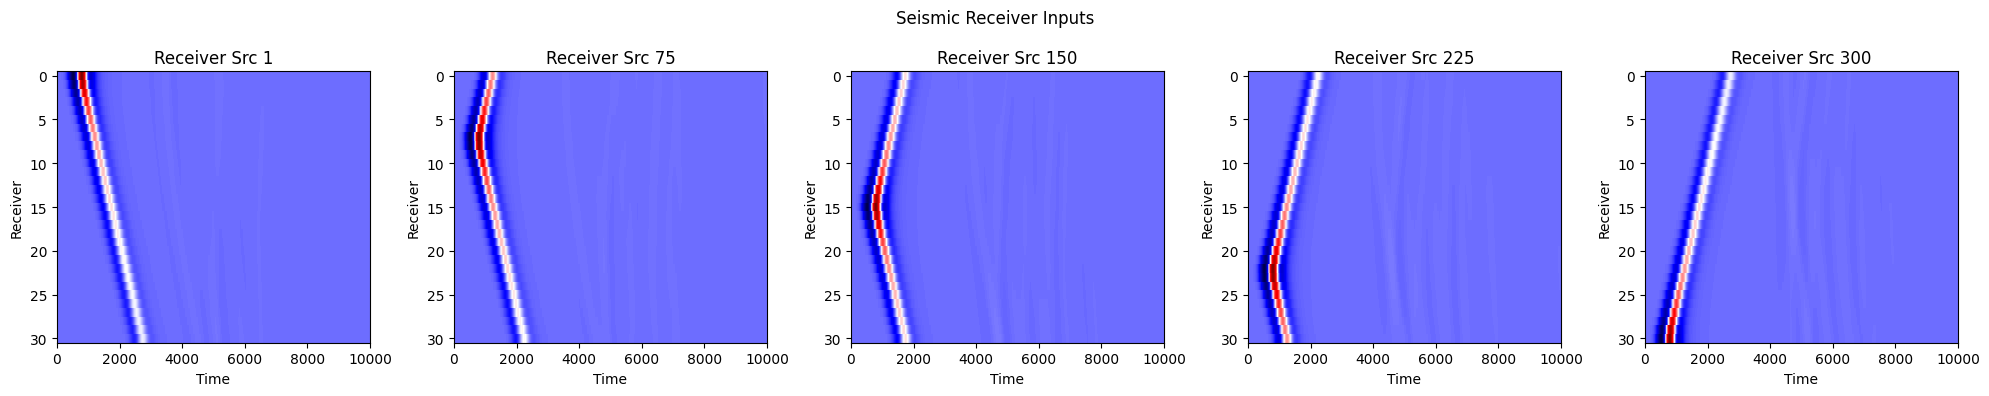

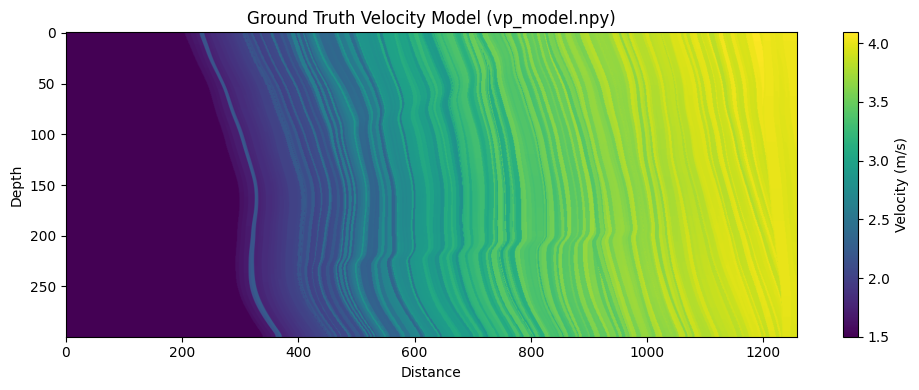

In [61]:
def visualize_sample(sample_path):
    source_positions = [1, 75, 150, 225, 300]
    receiver_data = []

    print(f"🔍 Visualizing sample at: {os.path.basename(sample_path)}")

    # Load seismic receiver inputs with error handling
    for src in source_positions:
        file_path = os.path.join(sample_path, f"receiver_data_src_{src}.npy")
        try:
            data = np.load(file_path)
            receiver_data.append(data)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder

    # Load velocity model
    try:
        vp_model = np.load(os.path.join(sample_path, "vp_model.npy"))
    except FileNotFoundError:
        print("vp_model.npy not found!")
        return
    except Exception as e:
        print(f"Error loading vp_model.npy: {e}")
        return

    # Plot seismic receiver inputs
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, (data, src) in enumerate(zip(receiver_data, source_positions)):
        axs[i].imshow(data.T, aspect='auto', cmap='seismic', interpolation='none')
        axs[i].set_title(f"Receiver Src {src}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Receiver")
    plt.suptitle("Seismic Receiver Inputs")
    plt.tight_layout()
    plt.show()

    # Plot velocity model
    plt.figure(figsize=(10, 4))
    plt.imshow(vp_model, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Velocity Model (vp_model.npy)")
    plt.xlabel("Distance")
    plt.ylabel("Depth")
    plt.colorbar(label='Velocity (m/s)')
    plt.tight_layout()
    plt.show()


sample_folders = sorted(glob("/content/sample_data/speed-and-structure-train/*"))
visualize_sample(sample_folders[0])



**INSPECT TEST DATA ** the total number of test samples (folders) in the test dataset.

Inspects the first test sample:

Loads and prints the shape and data type for each of the 5 receiver input files (receiver_data_src_*.npy).

Verifies that all necessary input files are present and correctly formatted.

Confirms the test dataset is ready for inference (no ground truth velocity model in test set)

In [62]:
# Path to test samples
test_dir = "/content/sample_data/speed-and-structure-test"
test_folders = sorted([f for f in glob(os.path.join(test_dir, "*")) if os.path.isdir(f)])
print(f"🧪 Total test samples: {len(test_folders)}")

# Pick one to inspect
test_sample_path = test_folders[0]
test_sample_id = os.path.basename(test_sample_path)
print(f"\n🔍 Inspecting test sample: {test_sample_id}")

# Load receiver data (no velocity ground truth in test set)
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(test_sample_path, f"receiver_data_src_{i}.npy")
    try:
        test_data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {test_data.shape}, dtype: {test_data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")
    except Exception as e:
        print(f"Error loading receiver_data_src_{i}.npy: {e}")

🧪 Total test samples: 150

🔍 Inspecting test sample: 0BFqBxnVIT368FwmdR
Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32


# Data preparation for Training
> PyTorch Dataset for Seismic Shot Gather Inputs and Velocity Models:
This cell defines a custom dataset class to efficiently load, resize, pad, and return seismic receiver data and ground-truth velocity models for use in deep segmentation models. It supports both training/validation (with ground truth) and test (input-only) modes.

In [63]:
class SeismicDataset(Dataset):
    """
    Loads 5 receiver shot gathers per sample, resizes to (300,1259),
    pads to (304,1264), and returns (x, y) for train/val or (x, id) for test.
    """
    def __init__(self, root, is_test=False, normalize=True):
        self.paths   = sorted(glob(os.path.join(root, "*")))
        self.is_test = is_test
        self.src_pos = [1, 75, 150, 225, 300]
        self.pad_h, self.pad_w = 304, 1264
        self.normalize = normalize

    def __len__(self): return len(self.paths)

    def _norm(self, x):
        # per-channel min-max to [0,1] (robust and simple)
        xs = []
        for ch in x:
            mn, mx = ch.min(), ch.max()
            xs.append((ch - mn) / (mx - mn + 1e-8))
        return np.stack(xs, axis=0).astype(np.float32)

    def __getitem__(self, i):
        folder = self.paths[i]
        x = np.stack([np.load(os.path.join(folder, f"receiver_data_src_{p}.npy")) for p in self.src_pos]).astype(np.float32)
        if self.normalize: x = self._norm(x)

        x = torch.from_numpy(x).unsqueeze(0)  # (1,5,H,W)
        x = F.interpolate(x, size=(300, 1259), mode='bilinear', align_corners=False).squeeze(0)  # (5,300,1259)

        pad_h = max(0, self.pad_h - x.shape[1])
        pad_w = max(0, self.pad_w - x.shape[2])
        x = F.pad(x, (0, pad_w, 0, pad_h))  # (left,right,top,bottom) -> (5,304,1264)

        if self.is_test:
            return x, os.path.basename(folder)

        y = torch.from_numpy(np.load(os.path.join(folder, "vp_model.npy")).astype(np.float32))  # (300,1259)
        y = F.pad(y, (0, pad_w, 0, pad_h))  # (304,1264)

        return x, y

full_dataset = SeismicDataset(train_dir)
sample = full_dataset[0][0]
print("Sample input shape after padding:", sample.shape)

Sample input shape after padding: torch.Size([5, 304, 1264])


# Model Defination & Training
>DeepLabV3+ Model Setup, Training Loop, and Visualization:
This cell defines the model, loss, training loop (with progress bars and checkpointing), and loss curve visualization for seismic velocity inversion using DeepLabV3+. All key parameters are tracked and reproducibility is ensured.


**Training Configuration, Model Factory & Utilities
Defines hyperparameters, DeepLabV3+ factory, MAPE loss, mixed-precision training loop, LR scheduler, checkpointing, and loss plotting.**

In [64]:
# Hyperparameters
HYPERPARAMS = {
    "encoder_name": "resnext50_32x4d",
    "encoder_weights": "imagenet",
    "in_channels": 5,
    "classes": 1,
    "activation": None,
    "upsampling": 4,            # SMP upsampling factor for DeepLabV3+
    "lr": 5e-4,
    "batch_size": 4,
    "epochs": 50,
    "weight_decay": 1e-4,
    "scheduler_patience": 5,
    "scheduler_factor": 0.5,
}

# Model factory (use core args for maximum SMP compatibility)
def get_model(params):
    model = smp.DeepLabV3Plus(
        encoder_name=params["encoder_name"],
        encoder_weights=params["encoder_weights"],
        in_channels=params["in_channels"],
        classes=params["classes"],
        activation=params["activation"],
        upsampling=params["upsampling"],
    )
    return model.to(device)

# MAPE loss
class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super().__init__(); self.epsilon = epsilon
    def forward(self, pred, target):
        return torch.mean(torch.abs((target - pred) / (target + self.epsilon)))

# Training loop with AMP, scheduler, checkpoint
def train_model(model, train_loader, val_loader, params):
    criterion = MAPELoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=params["scheduler_patience"],
    factor=params["scheduler_factor"]
)

    scaler   = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val = float("inf")

    for epoch in range(params["epochs"]):
        # --- Train ---
        model.train()
        tr_losses = []
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Train", leave=False):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                pred = model(xb).squeeze(1)           # (B,304,1264)
                loss = criterion(pred[:, :300, :1259], yb[:, :300, :1259])
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer); scaler.update()
            tr_losses.append(loss.item())

        train_loss = float(np.mean(tr_losses))
        history["train_loss"].append(train_loss)

        # --- Validate ---
        model.eval()
        va_losses = []
        with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{params['epochs']} - Val", leave=False):
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                pred = model(xb).squeeze(1)
                va_losses.append(MAPELoss()(pred[:, :300, :1259], yb[:, :300, :1259]).item())

        val_loss = float(np.mean(va_losses))
        history["val_loss"].append(val_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1:03d}/{params['epochs']} | Train MAPE: {train_loss:.5f} | Val MAPE: {val_loss:.5f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_deeplabv3plus_model.pth")
            print("  ✅ Saved new best model!")

            # save training info
            info = {
                "hyperparameters": params,
                "best_val_loss": best_val,
                "device": str(device),
                "python_version": platform.python_version(),
                "torch_version": torch.__version__,
                "cuda_available": torch.cuda.is_available(),
                "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
            }
            try:
                with open("training_info.json", "w") as f: json.dump(info, f, indent=4)
            except Exception as e:
                print("Warning saving training_info.json:", e)

    return history

def plot_loss(history, title="Train & Validation MAPE"):
    plt.figure(figsize=(8,5))
    plt.plot(history["train_loss"], label="Train MAPE")
    plt.plot(history["val_loss"], label="Val MAPE")
    plt.xlabel("Epoch"); plt.ylabel("MAPE"); plt.title(title)
    plt.grid(True); plt.legend(); plt.show()

**Data Splits & DataLoader Setup
Partitions the dataset into 60% training, 20% validation, and 20% internal test (frozen). Configures PyTorch DataLoaders with CUDA-aware settings (workers, pinning, persistence).**

In [65]:
cuda = torch.cuda.is_available()
loader_args = dict(num_workers=2 if cuda else 0, pin_memory=cuda, persistent_workers=cuda) if cuda else {}

full_dataset = SeismicDataset(train_dir)

idx_all = np.arange(len(full_dataset))
idx_trainval, idx_test_int = train_test_split(idx_all, test_size=0.20, random_state=42, shuffle=True)     # 20% internal test (frozen)
idx_train_60, idx_val_20   = train_test_split(idx_trainval, test_size=0.25, random_state=42, shuffle=True) # from the remaining 80%

print(f"Sizes | train: {len(idx_train_60)} | val: {len(idx_val_20)} | internal test: {len(idx_test_int)}")

BATCH_SIZE = HYPERPARAMS["batch_size"]

train_loader_60 = DataLoader(Subset(full_dataset, idx_train_60), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, **loader_args)
val_loader_20   = DataLoader(Subset(full_dataset, idx_val_20),   batch_size=1, shuffle=False, **loader_args)
test_loader_int = DataLoader(Subset(full_dataset, idx_test_int), batch_size=1, shuffle=False, **loader_args)

Sizes | train: 1200 | val: 400 | internal test: 400


**Model Training, Checkpoint Loading & Internal Test Evaluation
Trains DeepLabV3+ on the 60/20 split, restores the best checkpoint, and evaluates performance on the frozen 20% internal test set (MAPE).**

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

/tmp/ipython-input-2945132310.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/50 - Train:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipython-input-2945132310.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2945132310.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 001/50 | Train MAPE: 0.11321 | Val MAPE: 0.13746 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 002/50 | Train MAPE: 0.05074 | Val MAPE: 0.06680 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 003/50 | Train MAPE: 0.04499 | Val MAPE: 0.04258 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 004/50 | Train MAPE: 0.04125 | Val MAPE: 0.04595 | LR: 5.00e-04


Epoch 005/50 | Train MAPE: 0.03937 | Val MAPE: 0.19899 | LR: 5.00e-04


Epoch 006/50 | Train MAPE: 0.03688 | Val MAPE: 0.09456 | LR: 5.00e-04


Epoch 007/50 | Train MAPE: 0.03512 | Val MAPE: 0.04775 | LR: 5.00e-04


Epoch 008/50 | Train MAPE: 0.03295 | Val MAPE: 0.03801 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 009/50 | Train MAPE: 0.03267 | Val MAPE: 0.03570 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 010/50 | Train MAPE: 0.03247 | Val MAPE: 0.04046 | LR: 5.00e-04


Epoch 011/50 | Train MAPE: 0.03266 | Val MAPE: 0.03433 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 012/50 | Train MAPE: 0.03205 | Val MAPE: 0.04066 | LR: 5.00e-04


Epoch 013/50 | Train MAPE: 0.03238 | Val MAPE: 0.03392 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 014/50 | Train MAPE: 0.03167 | Val MAPE: 0.03440 | LR: 5.00e-04


Epoch 015/50 | Train MAPE: 0.03080 | Val MAPE: 0.03369 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 016/50 | Train MAPE: 0.03082 | Val MAPE: 0.03386 | LR: 5.00e-04


Epoch 017/50 | Train MAPE: 0.03070 | Val MAPE: 0.03265 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 018/50 | Train MAPE: 0.03053 | Val MAPE: 0.03387 | LR: 5.00e-04


Epoch 019/50 | Train MAPE: 0.03039 | Val MAPE: 0.03221 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 020/50 | Train MAPE: 0.03079 | Val MAPE: 0.03607 | LR: 5.00e-04


Epoch 021/50 | Train MAPE: 0.02985 | Val MAPE: 0.03195 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 022/50 | Train MAPE: 0.02960 | Val MAPE: 0.03064 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 023/50 | Train MAPE: 0.02972 | Val MAPE: 0.03275 | LR: 5.00e-04


Epoch 024/50 | Train MAPE: 0.03040 | Val MAPE: 0.03474 | LR: 5.00e-04


Epoch 025/50 | Train MAPE: 0.03036 | Val MAPE: 0.03417 | LR: 5.00e-04


Epoch 026/50 | Train MAPE: 0.03082 | Val MAPE: 0.03618 | LR: 5.00e-04


Epoch 027/50 | Train MAPE: 0.03101 | Val MAPE: 0.03210 | LR: 5.00e-04


Epoch 028/50 | Train MAPE: 0.03054 | Val MAPE: 0.04708 | LR: 2.50e-04


Epoch 029/50 | Train MAPE: 0.02950 | Val MAPE: 0.03301 | LR: 2.50e-04


Epoch 030/50 | Train MAPE: 0.02929 | Val MAPE: 0.03311 | LR: 2.50e-04


Epoch 031/50 | Train MAPE: 0.02897 | Val MAPE: 0.03087 | LR: 2.50e-04


Epoch 032/50 | Train MAPE: 0.02902 | Val MAPE: 0.03146 | LR: 2.50e-04


Epoch 033/50 | Train MAPE: 0.02887 | Val MAPE: 0.03069 | LR: 2.50e-04


Epoch 034/50 | Train MAPE: 0.02886 | Val MAPE: 0.03138 | LR: 1.25e-04


Epoch 035/50 | Train MAPE: 0.02869 | Val MAPE: 0.03078 | LR: 1.25e-04


Epoch 036/50 | Train MAPE: 0.02865 | Val MAPE: 0.03075 | LR: 1.25e-04


Epoch 037/50 | Train MAPE: 0.02868 | Val MAPE: 0.03110 | LR: 1.25e-04


Epoch 038/50 | Train MAPE: 0.02870 | Val MAPE: 0.03087 | LR: 1.25e-04


Epoch 039/50 | Train MAPE: 0.02859 | Val MAPE: 0.03049 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 040/50 | Train MAPE: 0.02880 | Val MAPE: 0.03081 | LR: 1.25e-04


Epoch 041/50 | Train MAPE: 0.02869 | Val MAPE: 0.03235 | LR: 1.25e-04


Epoch 042/50 | Train MAPE: 0.02881 | Val MAPE: 0.03097 | LR: 1.25e-04


Epoch 043/50 | Train MAPE: 0.02864 | Val MAPE: 0.03156 | LR: 1.25e-04


Epoch 044/50 | Train MAPE: 0.02873 | Val MAPE: 0.03155 | LR: 1.25e-04


Epoch 045/50 | Train MAPE: 0.02870 | Val MAPE: 0.03071 | LR: 6.25e-05


Epoch 046/50 | Train MAPE: 0.02849 | Val MAPE: 0.03050 | LR: 6.25e-05


Epoch 047/50 | Train MAPE: 0.02832 | Val MAPE: 0.03043 | LR: 6.25e-05
  ✅ Saved new best model!


Epoch 048/50 | Train MAPE: 0.02829 | Val MAPE: 0.03051 | LR: 6.25e-05


Epoch 049/50 | Train MAPE: 0.02833 | Val MAPE: 0.03071 | LR: 6.25e-05


Epoch 050/50 | Train MAPE: 0.02832 | Val MAPE: 0.03039 | LR: 6.25e-05
  ✅ Saved new best model!


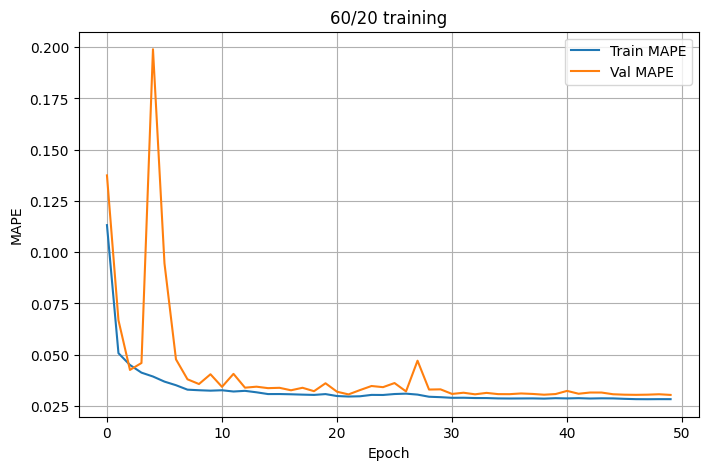

/tmp/ipython-input-2540306420.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


🔒 Internal Test MAPE (frozen 20%): 0.03019


In [66]:
# Train
model_60 = get_model(HYPERPARAMS)
hist_60  = train_model(model_60, train_loader_60, val_loader_20, HYPERPARAMS)
plot_loss(hist_60, title="60/20 training")

# Load BEST checkpoint saved during training
model_60 = get_model(HYPERPARAMS)
model_60.load_state_dict(torch.load("best_deeplabv3plus_model.pth", map_location=device))
model_60.eval()

# Evaluate frozen internal 20%
def eval_mape(model, loader):
    model.eval()
    losses = []
    loss_fn = MAPELoss().to(device)
    with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze(1)[:, :300, :1259]
            tgt  = yb[:, :300, :1259]
            losses.append(loss_fn(pred, tgt).item())
    return float(np.mean(losses))

internal_test_mape = eval_mape(model_60, test_loader_int)
print(f"🔒 Internal Test MAPE (frozen 20%): {internal_test_mape:.5f}")

**Final 80/20 Split & Official Test Loader
Rebuilds dataset with 80% training and 20% validation on all labeled data. Prepares DataLoaders and configures the 150-sample official test set (unlabeled) for inference.**

In [67]:
# Rebuild an 80/20 split on all labeled data
idx_train_80, idx_val_20b = train_test_split(idx_all, test_size=0.20, random_state=42, shuffle=True)
print(f"80/20 Sizes | train: {len(idx_train_80)} | val: {len(idx_val_20b)}")

train_loader_80 = DataLoader(Subset(full_dataset, idx_train_80), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, **loader_args)
val_loader_20b  = DataLoader(Subset(full_dataset, idx_val_20b),  batch_size=1, shuffle=False, **loader_args)

# Official 150-sample test set (no labels)
test_loader_official = DataLoader(SeismicDataset(test_dir, is_test=True), batch_size=4 if cuda else 1, shuffle=False, **loader_args)

80/20 Sizes | train: 1600 | val: 400


**Final Model Training (80/20 Split) & Checkpoint Recovery
Trains DeepLabV3+ on the full 80/20 split, logs learning curves, and restores the best checkpoint for inference and submission.**

/tmp/ipython-input-2945132310.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/50 - Train:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipython-input-2945132310.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2945132310.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 001/50 | Train MAPE: 0.10966 | Val MAPE: 0.05731 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 002/50 | Train MAPE: 0.05106 | Val MAPE: 0.06395 | LR: 5.00e-04


Epoch 003/50 | Train MAPE: 0.04193 | Val MAPE: 0.04766 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 004/50 | Train MAPE: 0.03901 | Val MAPE: 0.08346 | LR: 5.00e-04


Epoch 005/50 | Train MAPE: 0.03607 | Val MAPE: 0.06786 | LR: 5.00e-04


Epoch 006/50 | Train MAPE: 0.03522 | Val MAPE: 0.12685 | LR: 5.00e-04


Epoch 007/50 | Train MAPE: 0.03319 | Val MAPE: 0.09292 | LR: 5.00e-04


Epoch 008/50 | Train MAPE: 0.03202 | Val MAPE: 0.03739 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 009/50 | Train MAPE: 0.03234 | Val MAPE: 0.03701 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 010/50 | Train MAPE: 0.03184 | Val MAPE: 0.08265 | LR: 5.00e-04


Epoch 011/50 | Train MAPE: 0.03166 | Val MAPE: 0.03681 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 012/50 | Train MAPE: 0.03091 | Val MAPE: 0.05063 | LR: 5.00e-04


Epoch 013/50 | Train MAPE: 0.03041 | Val MAPE: 0.03179 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 014/50 | Train MAPE: 0.03035 | Val MAPE: 0.06215 | LR: 5.00e-04


Epoch 015/50 | Train MAPE: 0.03033 | Val MAPE: 0.03097 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 016/50 | Train MAPE: 0.03039 | Val MAPE: 0.03084 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 017/50 | Train MAPE: 0.02977 | Val MAPE: 0.03765 | LR: 5.00e-04


Epoch 018/50 | Train MAPE: 0.02960 | Val MAPE: 0.03491 | LR: 5.00e-04


Epoch 019/50 | Train MAPE: 0.02967 | Val MAPE: 0.04248 | LR: 5.00e-04


Epoch 020/50 | Train MAPE: 0.02960 | Val MAPE: 0.05017 | LR: 5.00e-04


Epoch 021/50 | Train MAPE: 0.03022 | Val MAPE: 0.03067 | LR: 5.00e-04
  ✅ Saved new best model!


Epoch 022/50 | Train MAPE: 0.03029 | Val MAPE: 0.03873 | LR: 5.00e-04


Epoch 023/50 | Train MAPE: 0.03035 | Val MAPE: 0.04423 | LR: 5.00e-04


Epoch 024/50 | Train MAPE: 0.03056 | Val MAPE: 0.03076 | LR: 5.00e-04


Epoch 025/50 | Train MAPE: 0.03045 | Val MAPE: 0.03808 | LR: 5.00e-04


Epoch 026/50 | Train MAPE: 0.02931 | Val MAPE: 0.03113 | LR: 5.00e-04


Epoch 027/50 | Train MAPE: 0.02975 | Val MAPE: 0.06228 | LR: 2.50e-04


Epoch 028/50 | Train MAPE: 0.02908 | Val MAPE: 0.03107 | LR: 2.50e-04


Epoch 029/50 | Train MAPE: 0.02923 | Val MAPE: 0.03127 | LR: 2.50e-04


Epoch 030/50 | Train MAPE: 0.02900 | Val MAPE: 0.03188 | LR: 2.50e-04


Epoch 031/50 | Train MAPE: 0.02891 | Val MAPE: 0.05574 | LR: 2.50e-04


Epoch 032/50 | Train MAPE: 0.02867 | Val MAPE: 0.03040 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 033/50 | Train MAPE: 0.02858 | Val MAPE: 0.03001 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 034/50 | Train MAPE: 0.02857 | Val MAPE: 0.03085 | LR: 2.50e-04


Epoch 035/50 | Train MAPE: 0.02867 | Val MAPE: 0.02983 | LR: 2.50e-04
  ✅ Saved new best model!


Epoch 036/50 | Train MAPE: 0.02850 | Val MAPE: 0.03379 | LR: 2.50e-04


Epoch 037/50 | Train MAPE: 0.02852 | Val MAPE: 0.03429 | LR: 2.50e-04


Epoch 038/50 | Train MAPE: 0.02857 | Val MAPE: 0.03005 | LR: 2.50e-04


Epoch 039/50 | Train MAPE: 0.02862 | Val MAPE: 0.03023 | LR: 2.50e-04


Epoch 040/50 | Train MAPE: 0.02862 | Val MAPE: 0.03121 | LR: 2.50e-04


Epoch 041/50 | Train MAPE: 0.02880 | Val MAPE: 0.03042 | LR: 1.25e-04


Epoch 042/50 | Train MAPE: 0.02840 | Val MAPE: 0.03090 | LR: 1.25e-04


Epoch 043/50 | Train MAPE: 0.02838 | Val MAPE: 0.03026 | LR: 1.25e-04


Epoch 044/50 | Train MAPE: 0.02836 | Val MAPE: 0.03068 | LR: 1.25e-04


Epoch 045/50 | Train MAPE: 0.02832 | Val MAPE: 0.03024 | LR: 1.25e-04


Epoch 046/50 | Train MAPE: 0.02823 | Val MAPE: 0.03025 | LR: 1.25e-04


Epoch 047/50 | Train MAPE: 0.02815 | Val MAPE: 0.02981 | LR: 1.25e-04
  ✅ Saved new best model!


Epoch 048/50 | Train MAPE: 0.02812 | Val MAPE: 0.03004 | LR: 1.25e-04


Epoch 049/50 | Train MAPE: 0.02812 | Val MAPE: 0.02994 | LR: 1.25e-04


Epoch 050/50 | Train MAPE: 0.02817 | Val MAPE: 0.02974 | LR: 1.25e-04
  ✅ Saved new best model!


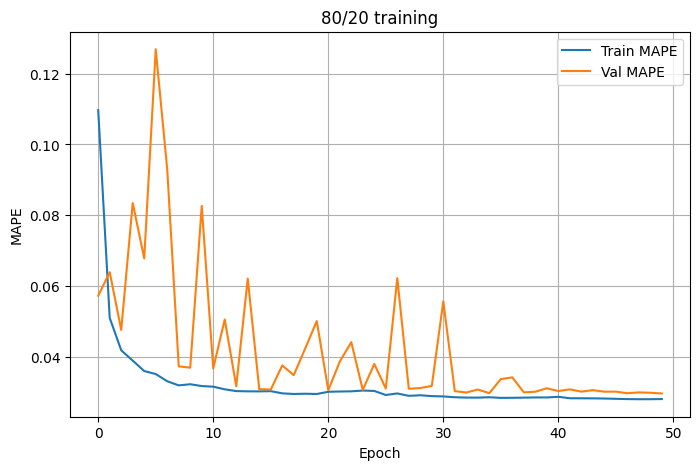

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [68]:
# Train final model
model_80 = get_model(HYPERPARAMS)
hist_80  = train_model(model_80, train_loader_80, val_loader_20b, HYPERPARAMS)
plot_loss(hist_80, title="80/20 training")

# Load best checkpoint saved in this run
model_80 = get_model(HYPERPARAMS)
model_80.load_state_dict(torch.load("best_deeplabv3plus_model.pth", map_location=device))
model_80.eval()

# Test-time Inference & Submission Builder

Runs batched inference on the 150 official test samples, writes a .npz with (300×1259) float64 predictions per sample ID, validates the file, and exports to Drive.

In [69]:
# Build submission for 150 official test samples
submission_path = "/content/speed_structure_submission.npz"
if os.path.exists(submission_path):
    os.remove(submission_path)

with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, sids in tqdm(test_loader_official, desc="Inference (official test)"):
        xb = xb.to(device, non_blocking=True)
        pred = model_80(xb).squeeze(1)[:, :300, :1259]                    # (B, 300, 1259)
        arr  = pred.detach().cpu().numpy().astype(np.float64)
        for i, sid in enumerate(sids):
            create_submission(sid, arr[i], submission_path)

print("✅ Submission written to:", submission_path)

# Sanity check
def validate_submission_file(sub_path, expected=150):
    if not os.path.exists(sub_path): return print("❌ File missing")
    data = np.load(sub_path); keys = list(data.keys())
    print(f"✅ {len(keys)} predictions found.")
    bad = [(k, v.shape, v.dtype) for k, v in data.items() if v.shape != (300,1259) or v.dtype != np.float64]
    if bad: print(f"⚠️ {len(bad)} bad entries:", bad[:3])
    else:   print("🏁 Submission looks good!")

validate_submission_file(submission_path)

# Persist to Drive
!cp -f /content/speed_structure_submission.npz /content/drive/MyDrive/Speed_and_Structure/
print("📁 Copied to Drive: /content/drive/MyDrive/Speed_and_Structure/speed_structure_submission.npz")

/tmp/ipython-input-3003620104.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Inference (official test): 100%|██████████| 38/38 [02:44<00:00,  4.32s/it]


✅ Submission written to: /content/speed_structure_submission.npz
✅ 150 predictions found.
🏁 Submission looks good!
📁 Copied to Drive: /content/drive/MyDrive/Speed_and_Structure/speed_structure_submission.npz
